In [ ]:
!pip install pykan

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.igtd import IGTD
from kan import *
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import sys
import os
import traceback
import time
import gc
import copy
import traceback
import torch.nn as nn
import cv2
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
#from torch.optim import LBFGS


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [4]:
folder="data/Riesgo-Cardiovascular-Residual"
filename="Dataset_2025-04-03.csv"
x_col=[
    "age", "diastolic_bp", "hba1c", "systolic_bp", "glucose",
    "triglycerides", "ldl_cholesterol", "creatinine", "waist_to_hip_ratio",
    "platelets", "hdl_cholesterol", "total_cholesterol", "hemoglobin", "hsCRP",
    "high_crp_hs"
]
target_col=["high_crp_hs"]

# Functions

### Load Dataset and Images

In [5]:
import os
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

def load_clean_and_preprocess(folder, file_name, x_col, target_col, batch_size=16, device='cuda'):
    # Load CSV
    df = pd.read_csv(os.path.join(folder, file_name))

    # Map recommended_split to integer codes
    split_mapping = {'train': 0, 'val': 1, 'test': 2}
    df['split_code'] = df['recommended_split'].map(split_mapping)

    # Separate target
    y = df[target_col]

    # Extract and scale features (including split_code temporarily)
    df_X = df[x_col + ['split_code']]
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(df_X), columns=df_X.columns)

    # Prepare final dataset
    result = {}

    for split_name, split_code in split_mapping.items():
        split_mask = df['split_code'] == split_code
        X_split = X_scaled[split_mask].drop(columns='split_code').drop(columns=target_col)
        y_split = y[split_mask]

        X_tensor = torch.tensor(X_split.values, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_split.values, dtype=torch.float32).reshape(-1, 1).to(device)

        result[f"{split_name}_input"] = X_tensor
        result[f"{split_name}_label"] = y_tensor

    return result

### Functions for KAN

In [6]:
def custom_fit(model, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, 
               grid_update_num=10, loss_fn=None, lr=1., start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
               metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', 
               singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['val_input'], dataset['val_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['val_loss'], 1D array of val losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
        best_model:
    '''

    if lamb > 0. and not model.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set model.save_act=True')
        
    old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(lamb)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    if opt == "Adam":
        optimizer = torch.optim.Adam(model.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.get_params(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32,
                          tolerance_change=1e-32,
                          tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['val_loss'] = []
    results['reg'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_val = dataset['val_input'].shape[0]
    else:
        batch_size = batch
        batch_size_val = batch

    global train_loss, reg_

    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if model.save_act:
            if reg_metric == 'edge_backward':
                model.attribute()
            if reg_metric == 'node_backward':
                model.node_attribute()
            reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
        else:
            reg_ = torch.tensor(0.)
        objective = train_loss + lamb * reg_
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    best_model_state = None
    best_epoch = -1
    best_metric = 0
    val_metric = 0
    for epoch in pbar:
        
        if epoch == steps-1 and old_save_act:
            model.save_act = True
            
        if save_fig and epoch % save_fig_freq == 0:
            save_act = model.save_act
            model.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        val_id = np.random.choice(dataset['val_input'].shape[0], batch_size_val, replace=False)

        if epoch % grid_update_freq == 0 and epoch < stop_grid_update_step and update_grid and epoch >= start_grid_update_step:
            try:
                model.update_grid(dataset['train_input'][train_id])
            except:
                print('Failed update_grid')
                return best_model_state, results, best_epoch

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if model.save_act:
                if reg_metric == 'edge_backward':
                    model.attribute()
                if reg_metric == 'node_backward':
                    model.node_attribute()
                reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_ = torch.tensor(0.)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = loss_fn_eval(model.forward(dataset['val_input'][val_id]), dataset['val_label'][val_id])
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())
        
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())

        if epoch % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | val_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(val_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
                val_metric = val_loss
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    val_metric = results[metric][-1]
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)

        if val_metric > best_metric:
            best_epoch = epoch
            best_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())

        if save_fig and epoch % save_fig_freq == 0:
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            model.save_act = save_act

    model.log_history('fit')
    # revert back to original state
    model.symbolic_enabled = old_symbolic_enabled
    print(f"✅ Best validation Accuracy: {best_metric:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [7]:
def grid_search_kan(dataset, output_dim=1):
    hidden_neuron_options = list(range(1, attributes // 2 + 2))
    grid_options = list(range(3, 7))
    lamb_options = [0.1, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07]

    top_models = []  # list of dicts: each will have 'loss', 'config', 'state_dict'

    for hidden in hidden_neuron_options:
        for grid in grid_options:
            for lamb in lamb_options:
                
                print(f"Testing width=[{attributes}, {hidden}, {output_dim}], lamb={lamb}, grid={grid}")
                model = KAN(width=[attributes, hidden, 1], grid=grid, k=3, seed=381, device=device)
                def train_acc_kan():
                    rounded = torch.round(torch.round(model(dataset['train_input'])[:,0]))
                    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
                    return torch.mean((clipped == dataset['train_label'][:,0]).type(dtype))
                
                def val_acc_kan():
                    rounded = torch.round(torch.round(model(dataset['val_input'])[:,0]))
                    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
                    return torch.mean((clipped == dataset['val_label'][:,0]).type(dtype))
                # Custom training
                model_state, _, best_epoch = custom_fit(model, dataset, opt="LBFGS", steps=20, lamb=lamb, 
                                                        metrics=(train_acc_kan, val_acc_kan), display_metrics=['train_acc_kan', 'val_acc_kan'])
                13
                5
                1-----> 0. 1.  2.  3.  4.
                
                Y_PRED = 0.25   1.03    0.45     0.8     1.6
                        0       1         0       1      2
                Y_TRUE = 0      1         1       1      1
                
                if model_state:
                    model.load_state_dict(model_state)
    
                    # Evaluate
                    clipped = torch.clamp(torch.round(model(dataset['test_input'])[:,0]), min=min_expected, max=max_expected)
                    avg_acc = torch.mean((clipped == dataset['test_label'][:,0]).type(dtype))
                    print(avg_acc)
                    # Save this model info
                    top_models.append({
                        "acc_test": avg_acc,
                        "config": {"hidden": hidden, "grid": grid, "lamb": lamb},
                        "state_dict": copy.deepcopy(model_state),
                        "best_epoch": best_epoch
                    })
                
                del model
                torch.cuda.empty_cache()
                gc.collect()

                # Keep only top 5
                top_models = sorted(top_models, key=lambda x: x["acc_test"], reverse=True)[:5]

    print("\n✅ Top 5 Configurations:")
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. width=[{attributes}, {cfg['hidden']}, {output_dim}], grid={cfg['grid']}, lamb={cfg['lamb']} | best_epoch={entry['best_epoch']} | acc_test={entry['acc_test']:.5f}")

    return top_models

### Plot Functions

In [8]:
def plot_training_ACC(y_true, y_pred, train_loss, val_loss):
    clipped = torch.clamp(torch.round(y_pred), min=min_expected, max=max_expected)
    acc = torch.mean((clipped == y_true).type(dtype))
    print(acc)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['train', 'val'])
    plt.ylabel('Accuracy')
    plt.xlabel('step')
    plt.yscale('log')

In [9]:
def plot_confusion_matrix(y_true_tensor, y_pred_tensor, title="Confusion Matrix"):
    # Move tensors to CPU and detach if necessary
    clipped = torch.clamp(torch.round(y_pred_tensor), min=min_expected, max=max_expected)
    
    
    y_true = y_true_tensor.detach().cpu().numpy().flatten()
    y_pred = clipped.detach().cpu().numpy().flatten()

    # Round predictions if they are float (e.g., from sigmoid or regression)
    if y_pred.dtype.kind in {'f'}:
        y_pred = y_pred.round()

    # Get sorted list of all unique labels
    all_labels = sorted(set(y_true) | set(y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_sorted_feature_importance(columns, importances):
    # Move to CPU and numpy if it's a GPU tensor
    if isinstance(importances, torch.Tensor):
        importances = importances.detach().cpu().numpy()

    # Pair columns and importances and sort by importance descending
    sorted_pairs = sorted(zip(columns, importances), key=lambda x: x[1], reverse=True)
    sorted_columns, sorted_importances = zip(*sorted_pairs)

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    plt.barh(sorted_columns, sorted_importances, color='royalblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances (Sorted)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Load Dataset and Images

In [11]:
dataset=load_clean_and_preprocess(folder, filename, x_col, target_col)

In [12]:
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)

Train data shape: torch.Size([252, 14])
Train target shape: torch.Size([252, 1])
Test data shape: torch.Size([70, 14])
Test target shape: torch.Size([70, 1])
Validation data shape: torch.Size([67, 14])
Validation target shape: torch.Size([67, 1])


In [13]:
attributes = 13
dtype = torch.get_default_dtype()
min_expected = 0.
max_expected = 1.

# Grid Search KAN

In [ ]:
top_models=grid_search_kan(dataset)

# Best KAN

In [148]:
del model
torch.cuda.empty_cache()
gc.collect()

218819

In [16]:
def train_acc_kan():
    rounded = torch.round(torch.round(model(dataset['train_input'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['train_label'][:,0]).type(dtype))

def val_acc_kan():
    rounded = torch.round(torch.round(model(dataset['val_input'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['val_label'][:,0]).type(dtype))

### 1. width=[13, 1, 1], grid=3, lamb=0.001 | best_epoch=0 | acc_test=0.71429

checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 1.00e+00 | val_acc_kan: 9.55e-01 |: 100%|███████████| 20/20 [00:31<00:00,  1.56s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.8507e-01 at 1 epoch
tensor(0.9571, device='cuda:0')


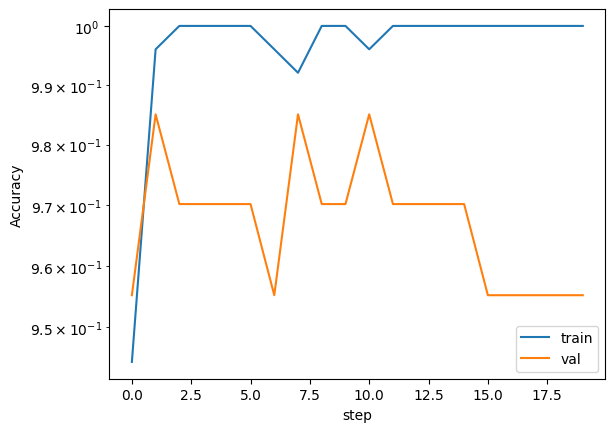

In [17]:
model = KAN(width=[attributes, 1, 1], grid=3, k=3, seed=381, device=device)
best_model_state, results, _ = custom_fit(model, dataset, opt="LBFGS", steps=20, lamb=0.001,
                                          metrics=(train_acc_kan, val_acc_kan), display_metrics=['train_acc_kan', 'val_acc_kan'])
model.load_state_dict(best_model_state)
plot_training_ACC(model, best_model_state, dataset['test_label'][:,0], model(dataset['test_input'])[:,0],
                  results['train_acc_kan'], results['val_acc_kan'])

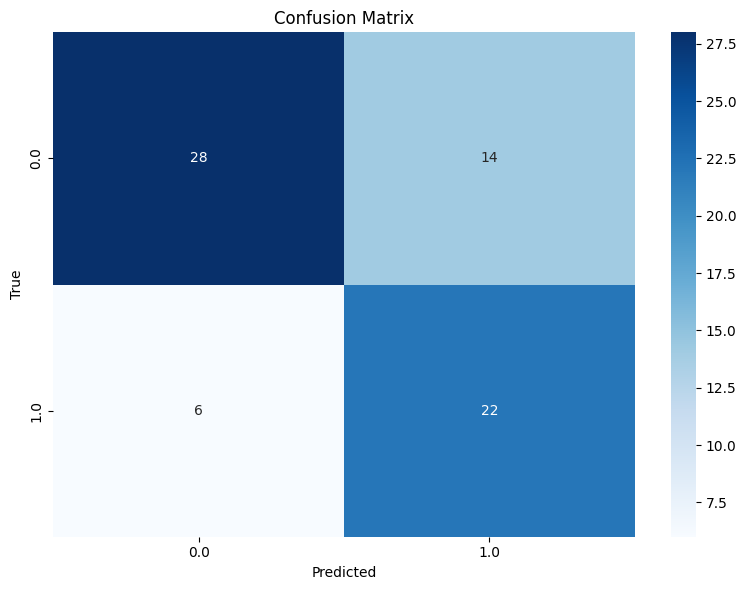

In [151]:
plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'])[:,0], title="Confusion Matrix")

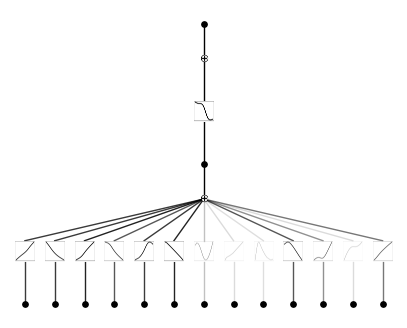

In [152]:
model.plot()

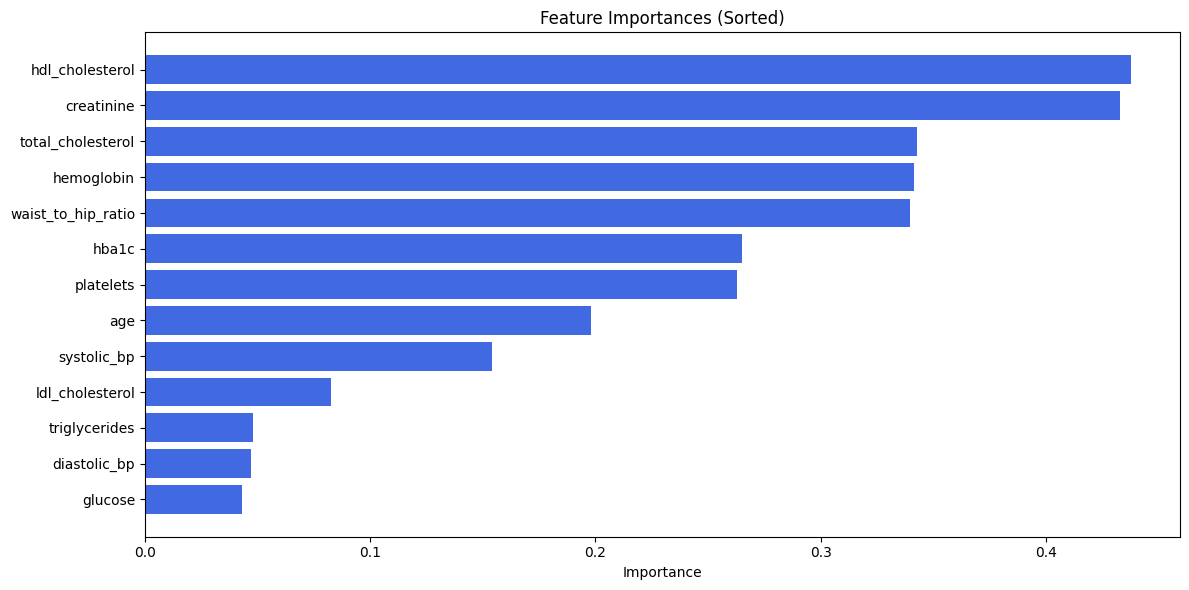

In [153]:
plot_sorted_feature_importance(x_col, model.feature_score)

### 2. width=[13, 1, 1], grid=5, lamb=0.001 | best_epoch=0 | acc_test=0.71429

In [154]:
del model
torch.cuda.empty_cache()
gc.collect()

72175

checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 8.93e-01 | val_acc_kan: 4.33e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.60it/s]

saving model version 0.1
✅ Best validation Accuracy: 6.7164e-01 at 0 epoch
tensor(0.4857, device='cuda:0')


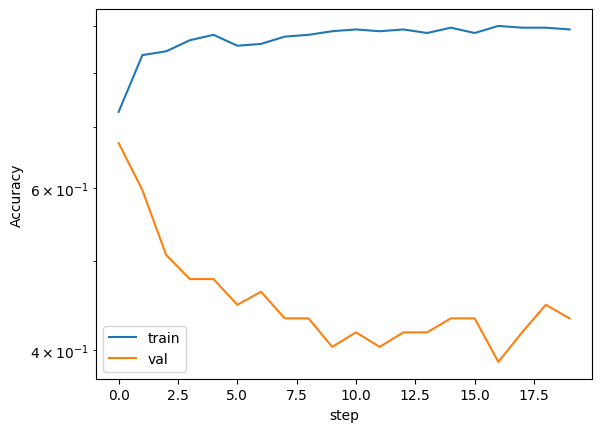

In [155]:
model = KAN(width=[attributes, 1, 1], grid=5, k=3, seed=381, device=device)
best_model_state, results, _ = custom_fit(model, dataset, opt="LBFGS", steps=20, lamb=0.001,
                                          metrics=(train_acc_kan, val_acc_kan), display_metrics=['train_acc_kan', 'val_acc_kan'])
model.load_state_dict(best_model_state)
plot_training_ACC(model, best_model_state, dataset['test_label'][:,0], model(dataset['test_input'])[:,0],
                  results['train_acc_kan'], results['val_acc_kan'])

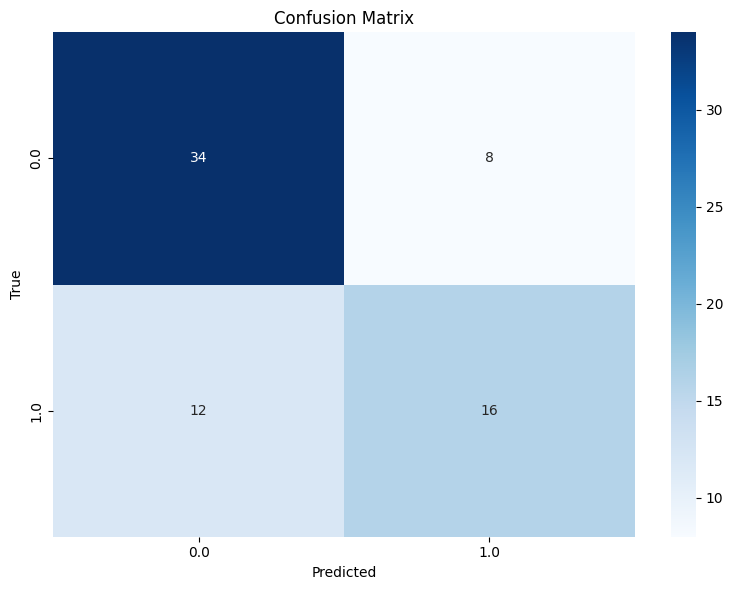

In [156]:
plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'])[:,0], title="Confusion Matrix")

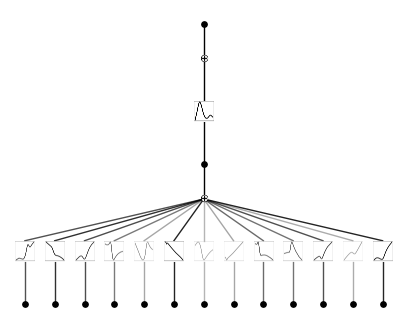

In [157]:
model.plot()

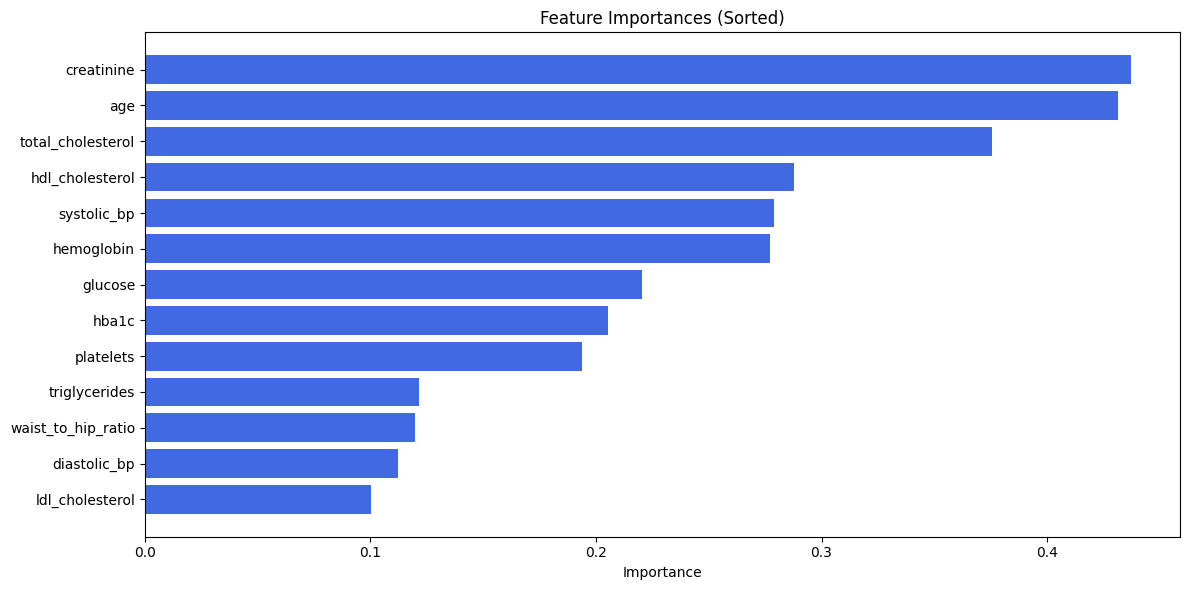

In [158]:
plot_sorted_feature_importance(x_col, model.feature_score)

# Best model from Grid Search

In [160]:
del model
torch.cuda.empty_cache()
gc.collect()

71157

In [15]:
def get_best_model(top_models):
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. width=[{attributes}, {cfg['hidden']}, {1}], grid={cfg['grid']}, lamb={cfg['lamb']} | best_epoch={entry['best_epoch']} | acc_test={entry['acc_test']:.5f}")
        model = KAN(width=[attributes, cfg['hidden'], 1], grid=cfg['grid'], k=3, seed=381, device=device)
        model.load_state_dict(entry['state_dict'])
        return model

In [162]:
model = get_best_model(top_models)

1. width=[13, 1, 1], grid=3, lamb=0.001 | best_epoch=0 | acc_test=0.71429
checkpoint directory created: ./model
saving model version 0.0


In [163]:
clipped = torch.clamp(torch.round(model(dataset['test_input'])[:,0]), min=min_expected, max=max_expected)
acc = torch.mean((clipped == dataset['test_label'][:,0]).type(dtype))
print(acc)

tensor(0.7143, device='cuda:0')


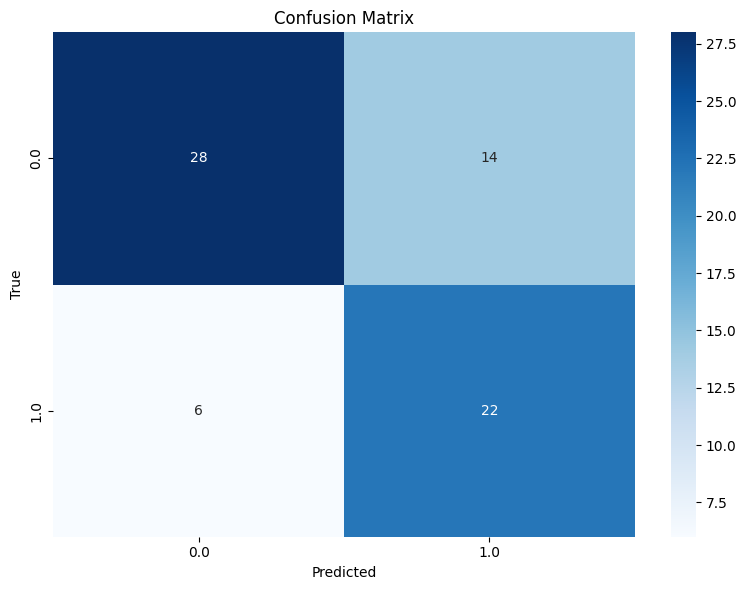

In [164]:
plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'])[:,0], title="Confusion Matrix")

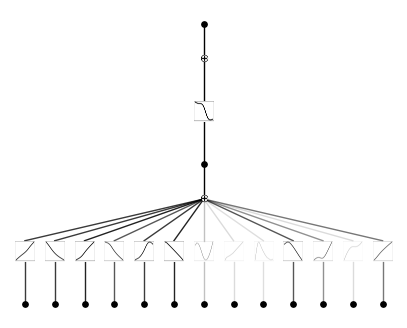

In [165]:
model.plot()

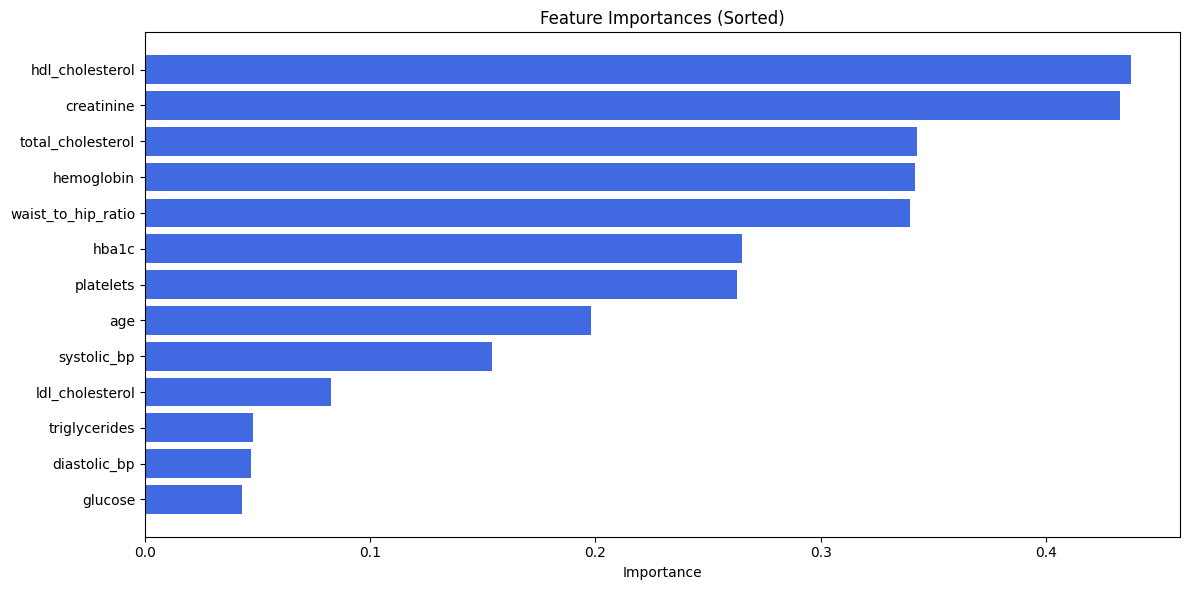

In [166]:
plot_sorted_feature_importance(x_col, model.feature_score)